<a href="https://colab.research.google.com/github/RipeMangoBox/STARRY/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Configuration Setup

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torchvision import datasets, transforms
from typing import List, Callable, Union, Any, TypeVar, Tuple
from sklearn.manifold import TSNE
import pandas as pd




# Step 2 - VAE Model

In [57]:
class VAE(nn.Module):
  def __init__(self, config: dict = None):
    super(VAE, self).__init__()

    self.image_size = config.image_size
    self.input_dim = config.input_channel
    self.layer_sizes = config.layer_sizes
    self.fc_dim = config.fc_dim
    self.latent_dim = config.latent_dim

    self.beta = 1

    self.encoder = Encoder(self.layer_sizes, self.latent_dim)
    self.decoder = Decoder(self.layer_sizes[::-1], self.latent_dim)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    x = x.view(-1, self.image_size * self.image_size)
    mu, log_var = self.encoder(x)
    z = self.reparameterize(mu, log_var)
    return self.decoder(z), mu, log_var

  def calc_loss(self, x, recon_x, mu, log_var):
    recons_loss = F.mse_loss(recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction="sum").div(x.shape[0])
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu** 2 - log_var.exp(), dim = 1), dim = 0)
    return recons_loss + self.beta * kld_loss

In [58]:
class Encoder(nn.Module):
    def __init__(self,
         layer_sizes: List,
         latent_dim: int):
        super().__init__()

        self.layer_sizes = layer_sizes.copy()

        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())

        self.mu = nn.Linear(self.layer_sizes[-1], latent_dim)
        self.log_var = nn.Linear(self.layer_sizes[-1], latent_dim)

    def forward(self, x):
        x = self.MLP(x)
        mu = self.mu(x)
        log_vars = self.log_var(x)

        return mu, log_vars

class Decoder(nn.Module):
  def __init__(self,
         layer_sizes: List,
         latent_dim: int):
    super().__init__()

    self.MLP = nn.Sequential()

    input_size = latent_dim

    for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
        self.MLP.add_module(
            name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
        if i+1 < len(layer_sizes):
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
        else:
            self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

  def forward(self, z):
    x = self.MLP(z)

    return x

# Step 3 - Training

In [59]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [60]:
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


In [61]:
MNIST_config = Config(
    image_size = 28,
    layer_sizes = [784, 256],
    fc_dim = 128,
    latent_dim = 64,
    batch_size = 128,
    epochs = 10,
    input_channel = 1,
)

transform=transforms.Compose([
    transforms.ToTensor()
])


In [62]:

dataset1 = datasets.MNIST('../data/', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data/', train=False,
                    transform=transform)
args = MNIST_config

# 超参
image_size, layer_sizes, fc_dim, latent_dim, batch_size, epochs, input_channel = vars(args).values()

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
model = VAE(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [64]:
print_freq = 200
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        recon, mu, log_var = model(images)
        loss = model.calc_loss(images, recon, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0


	 [199/469]: loss 44.234806060791016
	 [399/469]: loss 42.831504821777344
	 [468/469]: loss 43.276702880859375
Start training epoch 1
	 [199/469]: loss 38.36949920654297
	 [399/469]: loss 37.583045959472656
	 [468/469]: loss 35.82343292236328
Start training epoch 2
	 [199/469]: loss 35.2719612121582
	 [399/469]: loss 35.2704963684082
	 [468/469]: loss 34.97674560546875
Start training epoch 3
	 [199/469]: loss 34.621646881103516
	 [399/469]: loss 33.0321044921875
	 [468/469]: loss 33.112281799316406
Start training epoch 4
	 [199/469]: loss 33.08983612060547
	 [399/469]: loss 32.1078987121582
	 [468/469]: loss 32.399085998535156
Start training epoch 5
	 [199/469]: loss 32.74685287475586
	 [399/469]: loss 32.183834075927734
	 [468/469]: loss 32.89039611816406
Start training epoch 6
	 [199/469]: loss 31.927400588989258
	 [399/469]: loss 29.476821899414062
	 [468/469]: loss 32.170867919921875
Start training epoch 7
	 [199/469]: loss 31.967634201049805
	 [399/469]: loss 32.76188659667969
	 [

# Step 4 - Results

torch.Size([64, 784])


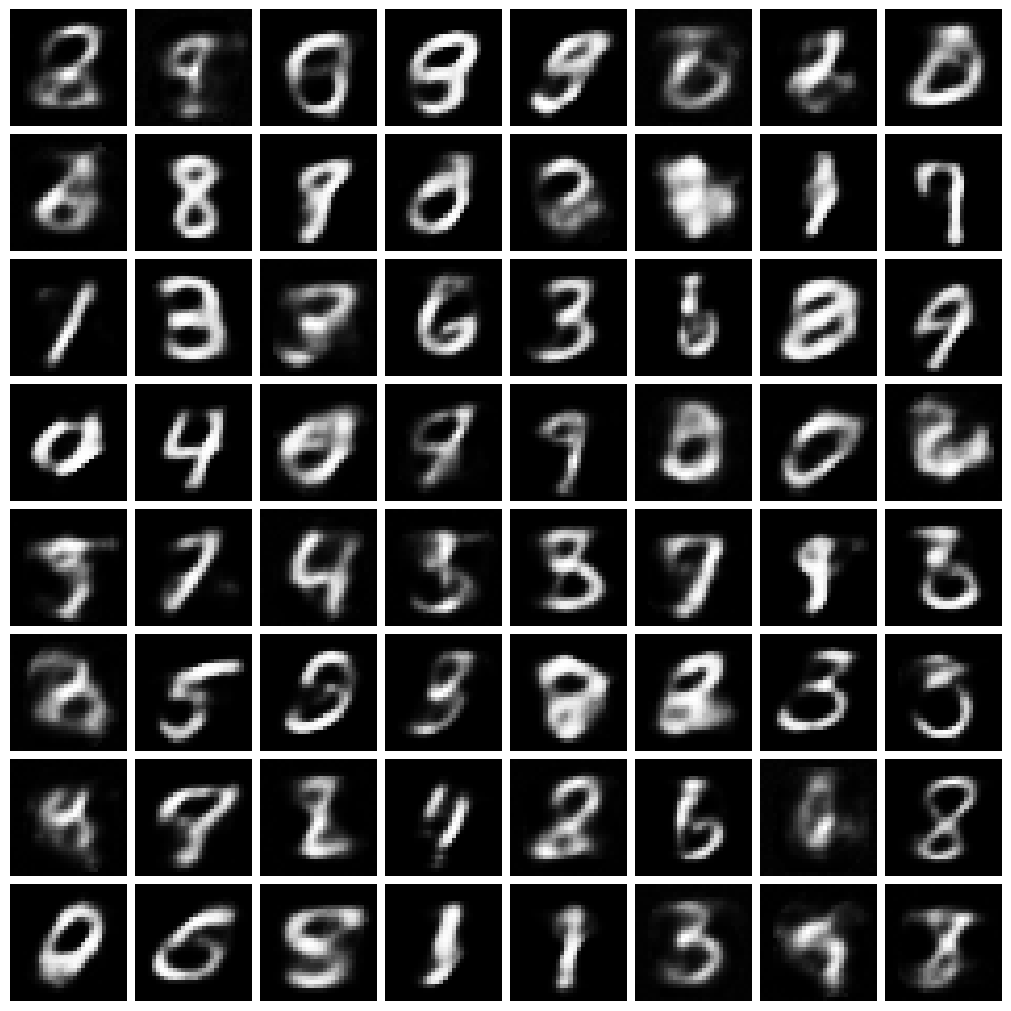

In [65]:
## generate new images by VAE

n_rows = 8
n_cols = 8

sample_zs = torch.randn(n_rows * n_cols, latent_dim).to(device)

model.eval()

with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    print(generated_imgs.shape)
    
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, input_channel, image_size, image_size)

fig = plt.figure(figsize=(10,  10), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)

for n_row in range(n_rows):
    for n_col in range(n_cols):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = generated_imgs[n_row, n_col]  # 获取图像数据
        f_ax.imshow(img.squeeze(), cmap='gray')  # 对于 MNIST，去除单通道维度
        f_ax.axis("off")

plt.show()

# Step 5 - Visualization

In [66]:
def plot_latent_space_tsne(variable='mu', nums=1000):
  model.eval()
  with torch.no_grad():
    latent_vectors = []
    labels = []
    for data, label in test_loader:
      data = data.to(device)
      recon_x, mu, logvar = model(data)

      z = model.reparameterize(mu, logvar) if variable == 'z' else mu
      latent_vectors.append(z.cpu())
      labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0)[:nums]
    labels = torch.cat(labels, dim=0)[:nums]

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=2023)
    latent_tsne = tsne.fit_transform(latent_vectors)

    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Visualization of Latent Space {variable}')
    plt.show()

### $\mu$的可视化

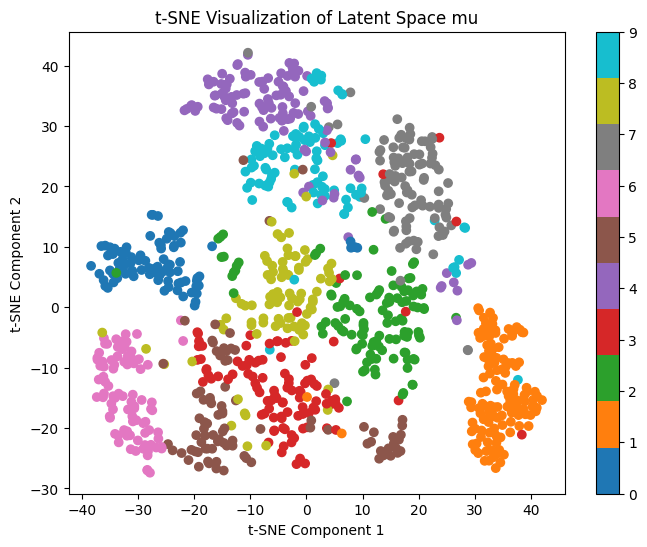

In [67]:
plot_latent_space_tsne('mu', 1000)

### z的可视化

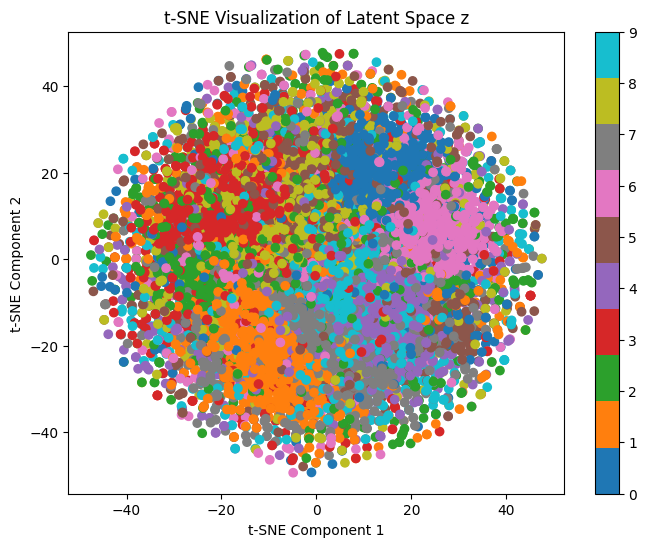

In [68]:
# 由于方差存在，z的可视化需要远比mu多的点才能看出效果
plot_latent_space_tsne('z', None)